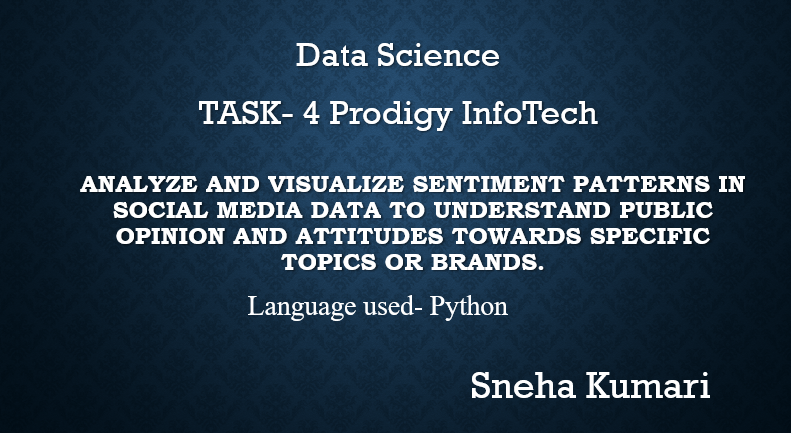

In [13]:
from IPython import display
display.Image("45.png")

The dataset consists of message, entity, and sentiment in Twitter. There are three classes in the dataset: positive, negative, and neutral. The messages that are not relevant to the entity should be regarded as neutral.

Tweet ID: ID of Tweet
Entity: Entity that Tweet talks about
Sentiment: Sentiment of the tweet text regarding the entity
Positive, Negative, Neutral, Irrelevant
Tweet Content: Tweet Text

In [1]:
# import libraries
## DATA ##
import numpy as np
import pandas as pd
import re

## NLP ##
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Visualization ##
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

## ML Modelling ##
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [23]:
import nltk
nltk.download('comtrans')
# Data is downloaded to /root/nltk_data/corpora/comtrans.zip

from zipfile import ZipFile
file_loc = '/root/nltk_data/corpora/comtrans.zip'
with ZipFile(file_loc, 'r') as z:
  z.extractall('/root/nltk_data/corpora/')

data = nltk.corpus.comtrans.aligned_sents('alignment-en-fr.txt')
print(data[0])

[nltk_data] Downloading package comtrans to /root/nltk_data...


<AlignedSent: 'Resumption of the se...' -> 'Reprise de la sessio...'>


In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
col_names = ['ID', 'Entity', 'Sentiment', 'Content']
train_df = pd.read_csv('/content/twitter_training.csv', names=col_names)
test_df = pd.read_csv('/content/twitter_validation.csv', names=col_names)

In [5]:
train_df.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
train_df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      686
dtype: int64

Since there are <b>686</b> null values in content (text), I will drop them.

In [7]:
train_df.dropna(subset=['Content'], inplace=True)

In [9]:
train_df['Sentiment'] = train_df['Sentiment'].replace('Irrelevant', 'Neutral')
test_df['Sentiment'] = test_df['Sentiment'].replace('Irrelevant', 'Neutral')

I will replace <b>irrelevant</b> to <b>neutral</b>.

In this section, I will first <b>analyze sentiment</b> distribution and sentiment distribution by top 3 entity, and then <b>NLP preprocess texts</b>, and lastly <b>visualize text distribution</b> by each sentiment.

SENTIMENTAL ANALYSIS
#Distribution of sentiments

In [10]:
sentiment_counts = train_df['Sentiment'].value_counts().sort_index()

sentiment_labels = ['Negative', 'Neutral', 'Positive']
sentiment_colors = ['red', 'grey', 'green']

fig = go.Figure(data=[go.Pie(labels=sentiment_counts.index,
                             values=sentiment_counts.values,
                             textinfo='percent+value+label',
                             marker_colors=sentiment_colors,
                             textposition='auto',
                             hole=.3)])

fig.update_layout(
    title_text='Sentiment Distribution',
    template='plotly_white',
    xaxis=dict(
        title='Sources',
    ),
    yaxis=dict(
        title='Number of Posts in Twitter',
    )
)

fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5,
                  opacity=0.8)

fig.show()

There are <b>41.9%</b> of neutral sentiment texts about entity, <b>30.2%</b> of negative sentiment texts about entity, and <b>27.9%</b> of positive sentiment texts about entity.

In [11]:
#DISTRIBUTION OF ENTITY

In [11]:
top10_entity_counts = train_df['Entity'].value_counts().sort_values(ascending=False)[:10]

fig = px.bar(x=top10_entity_counts.index,
             y=top10_entity_counts.values,
             color=top10_entity_counts.values,
             text=top10_entity_counts.values,
             color_continuous_scale='Blues')

fig.update_layout(
    title_text='Top 10 Twitter Entity Distribution',
    template='plotly_white',
    xaxis=dict(
        title='Entity',
    ),
    yaxis=dict(
        title='Number of Posts in Twitter',
    )
)

fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5,
                  opacity=0.8)

fig.show()

There are about <b>same</b> amount of data for each entity. <mark>MaddenNFL, LeagueOfLegends, CallOfDuty</mark> are 3 most distributed entities in the dataset.

SENTIMENT DISTRIBUTION IN TOP 3 ENTITIES

In [12]:
top3_entity_df = train_df['Entity'].value_counts().sort_values(ascending=False)[:3]
top3_entity = top3_entity_df.index.tolist()
sentiment_by_entity = train_df.loc[train_df['Entity'].isin(top3_entity)].groupby('Entity')['Sentiment'].value_counts().sort_index()

sentiment_labels = ['Negative', 'Neutral', 'Positive']
sentiment_colors = ['red', 'grey', 'green']

row_n = 1
col_n = 3

fig = make_subplots(rows=row_n, cols=col_n,
                    specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=top3_entity)

for i, col in enumerate(top3_entity):
    fig.add_trace(
        go.Pie(labels=sentiment_labels,
                values=sentiment_by_entity[col].values,
                textinfo='percent+value+label',
                marker_colors=sentiment_colors,
                textposition='auto',
                name=col),
            row=int(i/col_n)+1, col=int(i%col_n)+1)

fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5,
                  opacity=0.8)

fig.show()

There are <b>71.3%</b> negative sentiment tweets about MaddenNFL, <b>47.5%</b> neutral sentiment tweets about LeagueOfLegends, <b>44.1%</b> neutral sentiment tweets about CallOfDuty.

In [13]:
def get_all_string(sentences):
    sentence = ''
    for words in sentences:
        sentence += words
    sentence = re.sub('[^A-Za-z0-9 ]+', '', sentence)
    sentence = re.sub(r'http\S+', '', sentence)
    sentence = sentence.lower()
    return sentence

def get_word(sentence):
    return nltk.RegexpTokenizer(r'\w+').tokenize(sentence)

def remove_stopword(word_tokens):
    stopword_list = stopwords.words('english')
    filtered_tokens = []

    for word in word_tokens:
        if word not in stopword_list:
            filtered_tokens.append(word)
    return filtered_tokens

def lemmatize_words(filtered_tokens):
    lemm = WordNetLemmatizer()
    cleaned_tokens = [lemm.lemmatize(word) for word in filtered_tokens]
    return cleaned_tokens

In [14]:
def create_freq_df(cleaned_tokens):
    fdist = nltk.FreqDist(cleaned_tokens)
    freq_df = pd.DataFrame.from_dict(fdist, orient='index')
    freq_df.columns = ['Frequency']
    freq_df.index.name = 'Term'
    freq_df = freq_df.sort_values(by=['Frequency'], ascending=False)
    freq_df = freq_df.reset_index()
    return freq_df

In [15]:
def preprocess(series):
    all_string = get_all_string(series)
    words = get_word(all_string)
    filtered_tokens = remove_stopword(words)
    cleaned_tokens = lemmatize_words(filtered_tokens)
    return cleaned_tokens

In [16]:
def plot_text_distribution(x_df, y_df, color, title, xaxis_text, yaxis_text):

    fig = px.bar(x=x_df,
                y=y_df,
                color=y_df,
                text=y_df,
                color_continuous_scale=color)

    fig.update_layout(
        title_text=title,
        template='plotly_white',
        xaxis=dict(
            title=xaxis_text,
        ),
        yaxis=dict(
            title=yaxis_text,
        )
    )

    fig.update_traces(marker_line_color='black',
                    marker_line_width=1.5,
                    opacity=0.8)

    fig.show()

In [17]:
def create_wordcloud(freq_df, title, color):

    data = freq_df.set_index('Term').to_dict()['Frequency']

    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800,
               height=400,
               max_words=100,
               colormap= color,
               max_font_size=200,
               min_font_size = 1 ,
               random_state=8888,
               background_color='white').generate_from_frequencies(data)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

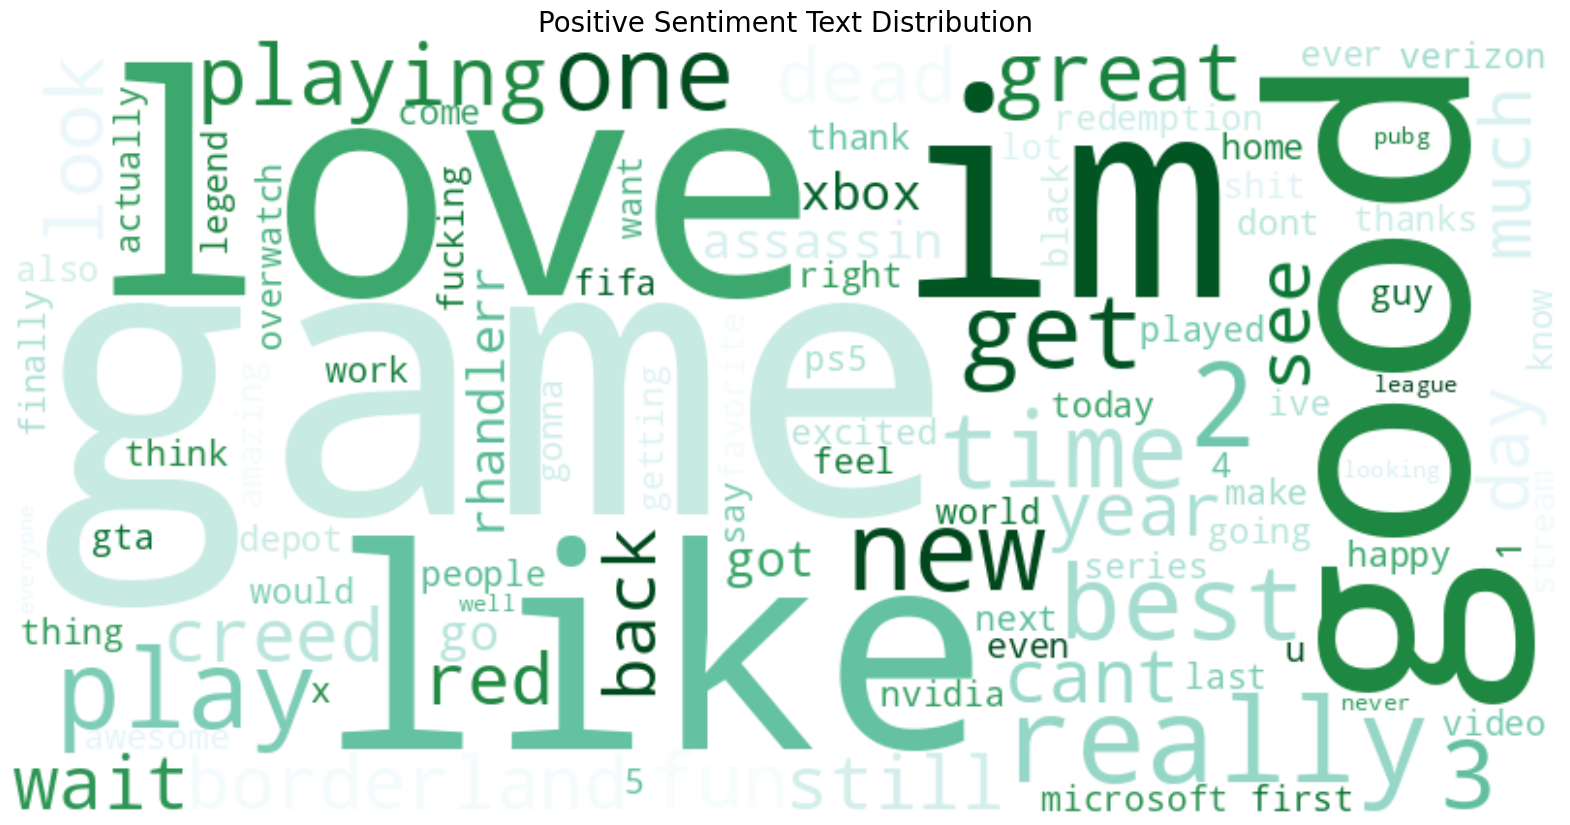

In [28]:
positive_words = preprocess(train_df.loc[train_df['Sentiment'] == 'Positive']['Content'])
positive_words_df = create_freq_df(positive_words)
top10_positive_words = positive_words_df[:10]

plot_text_distribution(top10_positive_words['Term'], top10_positive_words['Frequency'],
                  'Greens', 'Top 10 Positive Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(positive_words_df, 'Positive Sentiment Text Distribution', 'BuGn')

<div id='2.2.3' style='background-color:#9FDFFF;padding:2px;border-radius:25px'>
    <h4 style='font-family:Impact; color:black'>&nbsp 2.2.3 Negative Sentiment Text Distribution</h4>
</div>

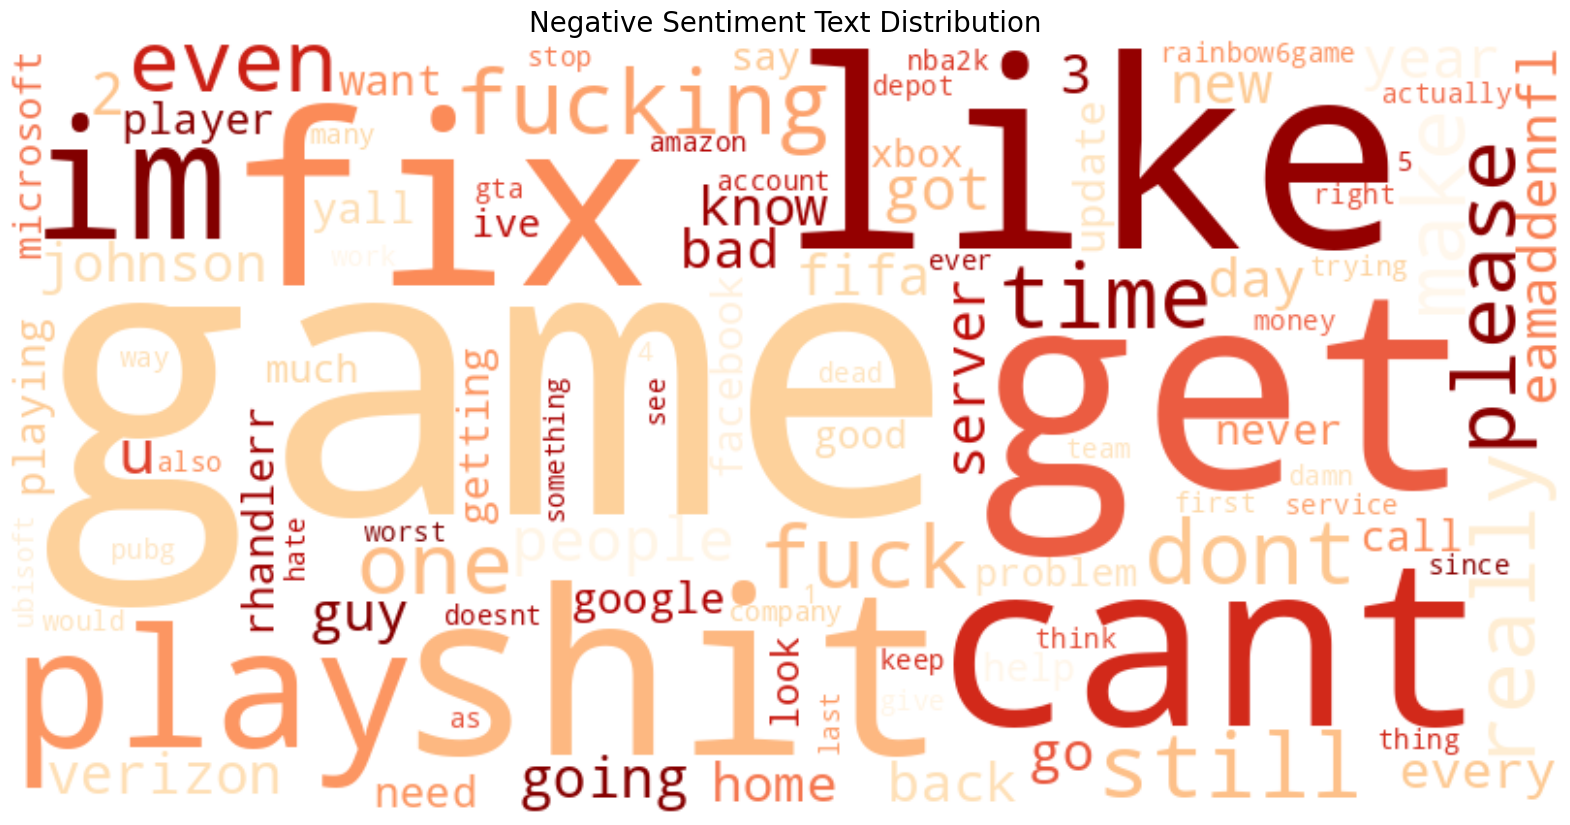

In [29]:
negative_words = preprocess(train_df.loc[train_df['Sentiment'] == 'Negative']['Content'])
negative_words_df = create_freq_df(negative_words)
top10_negative_words = negative_words_df[:10]

plot_text_distribution(top10_negative_words['Term'], top10_negative_words['Frequency'],
                  'Reds', 'Top 10 Negative Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(negative_words_df, 'Negative Sentiment Text Distribution', 'OrRd')

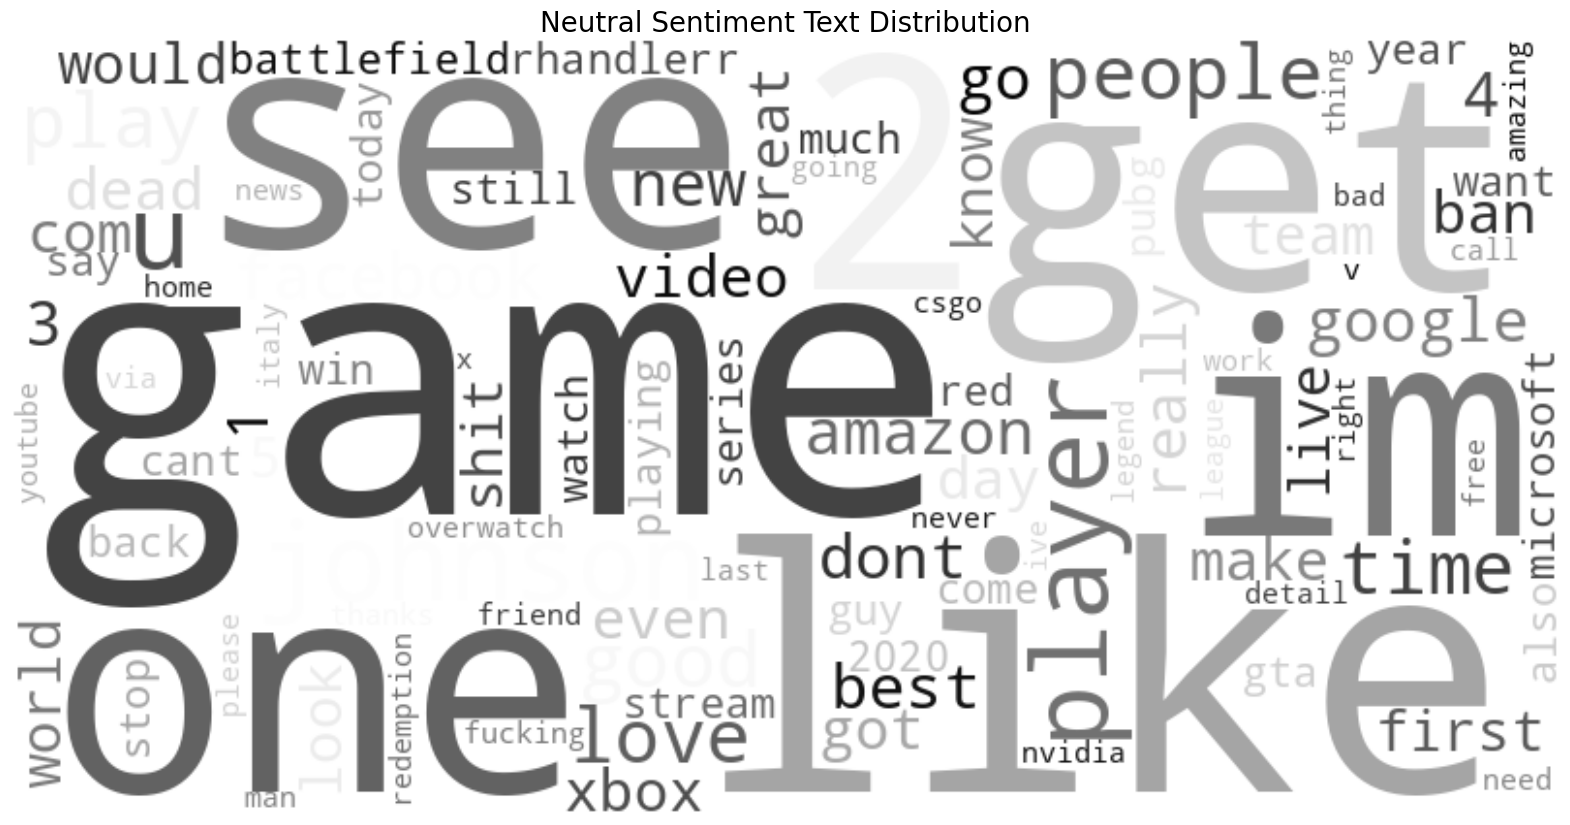

In [30]:
neutral_words = preprocess(train_df.loc[train_df['Sentiment'] == 'Neutral']['Content'])
neutral_words_df = create_freq_df(neutral_words)
top10_neutral_words = neutral_words_df[:10]

plot_text_distribution(top10_neutral_words['Term'], top10_neutral_words['Frequency'],
                  'Greys', 'Top 10 Neutral Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(neutral_words_df, 'Neutral Sentiment Text Distribution', 'binary_r')